<h2>Visualizing image-specific class saliency map in classification ConvNets in Pytorch</h2>

Recently I started to explore pytorch framework for creating deep learning models. Having worked with tensorflow for past few years, I found myself spending most of the my time just to figure out how to do 'X'. Although tensorflow is great for productionizing ml models, I wished to have a framework which would help me to express my ideas easily in code for faster prototyping. I was pleasently surprised by the fact that how easy pytorch makes it to express your ideas in code and run experiments. After going through the basics of pytorch I decided to implement the image-specific Class Saliency Visualisation method as described in https://arxiv.org/abs/1312.6034.

Saliency refers to what’s noticeable or important in an image. In context of convolution neural networks Saliency map for an image represents the important pixels in the image that influence the prediction of network.


In [1]:
import torch
import torchvision
import  torchvision.transforms as transforms

In [2]:
#load pretrained resnet model
model = torchvision.models.resnet50(pretrained=True)
print(model)

#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,          
])

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def saliency(img, model):
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.show()

In [4]:
!wget https://www.healthline.com/hlcmsresource/images/Lifestyle/Stingray_Water-732x549-Thumbnail.jpg -O sting.jpg

--2020-07-31 08:30:13--  https://www.healthline.com/hlcmsresource/images/Lifestyle/Stingray_Water-732x549-Thumbnail.jpg
Resolving www.healthline.com (www.healthline.com)... 13.224.0.65, 13.224.0.40, 13.224.0.46, ...
Connecting to www.healthline.com (www.healthline.com)|13.224.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46502 (45K) [image/jpeg]
Saving to: ‘sting.jpg’

sting.jpg           100%[===================>]  45.41K  --.-KB/s    in 0.009s  

2020-07-31 08:30:14 (5.19 MB/s) - ‘sting.jpg’ saved [46502/46502]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


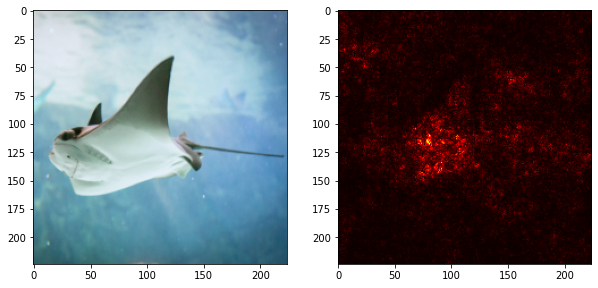

In [5]:
from PIL import Image
img = Image.open('sting.jpg').convert('RGB')
saliency(img, model)

In [6]:
!wget https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313__340.jpg -O puppy.jpg

--2020-07-31 08:30:19--  https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313__340.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.21.183, 104.18.20.183, 2606:4700::6812:15b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.21.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27076 (26K) [image/jpeg]
Saving to: ‘puppy.jpg’

puppy.jpg           100%[===================>]  26.44K  --.-KB/s    in 0s      

2020-07-31 08:30:19 (68.3 MB/s) - ‘puppy.jpg’ saved [27076/27076]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


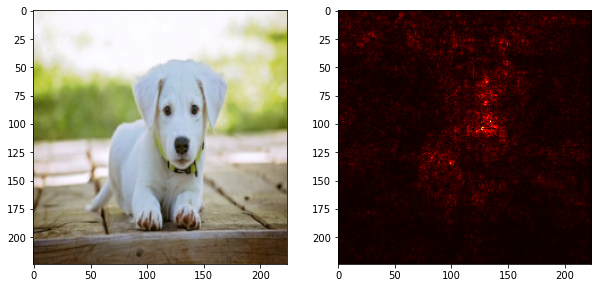

In [7]:
img = Image.open('puppy.jpg').convert('RGB')
saliency(img, model)

In [8]:
!wget https://cdn.shopify.com/s/files/1/0357/2432/9005/products/sfskyl-7540_sahara_2._large.jpg?v=159130274733 -O hat.jpg

--2020-07-31 08:30:24--  https://cdn.shopify.com/s/files/1/0357/2432/9005/products/sfskyl-7540_sahara_2._large.jpg?v=159130274733
Resolving cdn.shopify.com (cdn.shopify.com)... 151.101.0.104, 151.101.64.104, 151.101.128.104, ...
Connecting to cdn.shopify.com (cdn.shopify.com)|151.101.0.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30631 (30K) [image/jpeg]
Saving to: ‘hat.jpg’

hat.jpg             100%[===================>]  29.91K  --.-KB/s    in 0.008s  

2020-07-31 08:30:24 (3.49 MB/s) - ‘hat.jpg’ saved [30631/30631]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


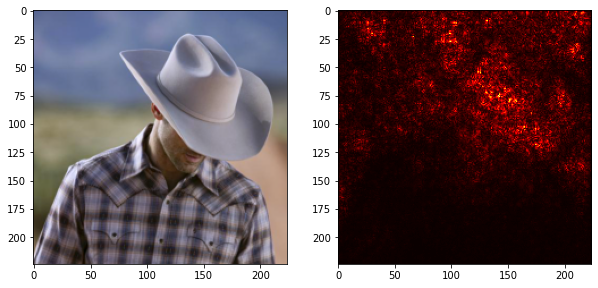

In [9]:
img = Image.open('hat.jpg').convert('RGB')
saliency(img, model)